In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance as dist
from matplotlib import cm

# Define functions: Kernel, interpolation

Kernel function

In [2]:
def phi(const, point, point_n):
    result = np.exp(- const * dist.euclidean(point, point_n) ** 2)
    return result

Interpolation function

In [3]:
def intpl_func(point, point_n, ma, const):
    mat = []
    for i in range(len(point_n)):
        mat.append(phi(const, point, point_n[i]))
    result = np.dot(mat, ma)
    return result

# Determine parameters

In [4]:
start_fr = 200 # start frame
end_fr = start_fr + 1 # end frame
const = 1 # constant in kernel
scaling = 0.005 # scaling of position vectors in data
weight = 1.5 # weight of IQR method
grid_number_x = 50 # dense of x-axis grid for plotting interpolated functions
grid_number_y = 50

# Data processing

Read data, and screen data for the particular frames

In [5]:
data = pd.read_csv('MOT16-04.csv')
df = data.loc[:,['frame_id','pedestrianId','Xt','Yt']]

start_df = df.loc[(df['frame_id'] == start_fr)].values
end_df = df.loc[(df['frame_id'] == end_fr)].values

Find same ped_id in start/end frames and calculate position/speed vectors and norm

In [6]:
df_vector = []
for i in range(len(start_df)):
    for j in range(len(end_df)):
        if start_df[i][1] == end_df[j][1]:
            df_vector.append([start_df[i][1], start_df[i][2], start_df[i][3],
                              end_df[j][2] - start_df[i][2], end_df[j][3] - start_df[i][3],
                              ((end_df[j][2] - start_df[i][2])**2 + (end_df[j][3] - start_df[i][3])**2)**0.5])

df_vector = pd.DataFrame(df_vector, columns = ['Ped_id','Xt','Yt','U','V','Norm'])

Remove outliers from norm, by the IQR method

In [7]:
outlier = []
norm_list = df_vector['Norm'].tolist()
norm_list.sort()

quantile_25 = np.percentile(norm_list, 25)
quantile_75 = np.percentile(norm_list, 75)

IQR = quantile_75 - quantile_25
IQR_weight = IQR * weight

lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight

ini_vector = df_vector.loc[(df_vector['Norm'] >= lowest) & (df_vector['Norm'] <= highest)]

# Calculate interpolation function

Calculate coefficients of interpolation functions for speed vectors (u,v): u(alpha), v(beta)

In [8]:
ini_xy = ini_vector.loc[:,['Xt','Yt']].values * scaling
ini_u = ini_vector.loc[:,['U']].values * scaling
ini_v = ini_vector.loc[:,['V']].values * scaling

phi_mat = []
for i in range(len(ini_xy)):
    phi_mat_row = []
    for j in range(len(ini_xy)):
        phi_mat_row.append(phi(const, ini_xy[j], ini_xy[i]))
    phi_mat.append(phi_mat_row)

alpha = np.linalg.solve(phi_mat, ini_u)
beta = np.linalg.solve(phi_mat, ini_v)

Calculate interpolation functions

In [9]:
min_x = min(ini_xy[:,0])
max_x = max(ini_xy[:,0])
min_y = min(ini_xy[:,1])
max_y = max(ini_xy[:,1])

grid_x0 = np.linspace(min_x - (100 * scaling), max_x + (100 * scaling), grid_number_x)
grid_y0 = np.linspace(min_y - (100 * scaling), max_y + (100 * scaling), grid_number_y)

grid_x, grid_y = np.meshgrid(grid_x0, grid_y0)
grid_xy = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

intpl_u = []
intpl_v = []
for xi, yi in zip(grid_xy[:,0], grid_xy[:,1]):
    intpl_u.append(intpl_func([xi, yi], ini_xy, alpha, const))
    intpl_v.append(intpl_func([xi, yi], ini_xy, beta, const))

Draw figures

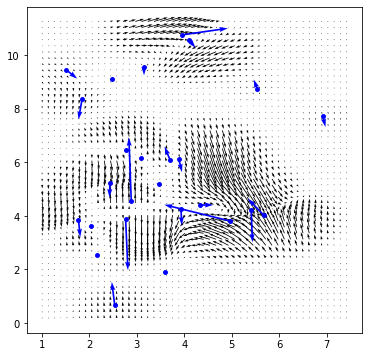

In [10]:
plt.figure(figsize=(6, 6))
plt.quiver(grid_xy[:,0], grid_xy[:,1], intpl_u, intpl_v)
plt.scatter(ini_xy[:,0], ini_xy[:,1], s=15, c='b')
plt.quiver(ini_xy[:,0], ini_xy[:,1], ini_u, ini_v, width=0.005, color='blue')
plt.show()